# 🚀 GPT Acadêmico: Arquitetura Autoregressiva Corrigida

Este notebook implementa um modelo **GPT-style** funcional. Diferente de modelos de tradução (Encoder-Decoder), o GPT usa apenas o **Decoder** para prever a próxima palavra em uma sequência contínua.

## 🧠 O que corrigimos:
1. **Vetorização Preservada:** Impedimos que o Keras remova o token especial `[SEP]`.
2. **Masking Real:** Ativamos `mask_zero=True` para que o modelo ignore o padding.
3. **Causal Attention:** Garantimos que o modelo não "espere" a resposta durante o treino.
4. **Visualização 3D:** Usamos **PCA** para reduzir os embeddings de 64D para 3D, permitindo a visualização matemática do espaço semântico.

In [7]:
import pandas as pd
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Carregamento do Dataset
try:
    with open('dataset_chat_generativo_v2.json', 'r', encoding='utf-8') as f:
        data = json.load(f)
except FileNotFoundError:
    # Fallback caso o arquivo não exista no ambiente atual
    data = [{"pergunta": "Oi", "resposta": "Olá tudo bem"}]

df = pd.DataFrame(data)

# 2. Preparação da Sequência GPT: "Pergunta [SEP] Resposta"
df["texto"] = df["pergunta"] + " [SEP] " + df["resposta"]

MAX_VOCAB_SIZE = 1000
MAX_SEQUENCE_LEN = 30 # Aumentado para caber pergunta + resposta

# Customização para NÃO remover os colchetes do [SEP]
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    # Remove pontuações exceto colchetes
    return tf.strings.regex_replace(lowercase, "[^a-z0-9\s\[\]]", "")

vectorize_layer = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    standardize=custom_standardization,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN
)
vectorize_layer.adapt(df["texto"].values)

# 3. Criando X (Entrada) e Y (Alvo deslocado)
# Exemplo: X="Oi [SEP] Tudo", Y="[SEP] Tudo bem"
sequencias = vectorize_layer(df["texto"].values)
X_train = sequencias[:, :-1]
Y_train = sequencias[:, 1:]

print(f"Vocabulário: {len(vectorize_layer.get_vocabulary())} palavras")
print(f"Exemplo X[0]: {X_train[0].numpy()}")

Vocabulário: 1000 palavras
Exemplo X[0]: [  1 805 406   4   1 805 406   9  15 167  22 665   1   1   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


## 3. Arquitetura Transformer (Decoder-Only)

Aqui implementamos o **Positional Embedding** com suporte a `mask_zero` e o bloco de **Causal Self-Attention**.

In [9]:
class GPTBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        # Causal Masking é aplicado aqui internamente pelo Keras se usarmos use_causal_mask
        attn_output = self.att(inputs, inputs, use_causal_mask=True)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_gpt_model():
    inputs = layers.Input(shape=(MAX_SEQUENCE_LEN-1,))
    
    # Embedding com MASK_ZERO para ignorar o padding (0)
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, 64, mask_zero=True)
    x = embedding_layer(inputs)
    
    # Adicionando um bloco Transformer
    x = GPTBlock(64, 4, 128)(x)
    
    # Saída: Probabilidade sobre o vocabulário
    outputs = layers.Dense(MAX_VOCAB_SIZE, activation="softmax")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy")
    return model, embedding_layer

model, emb_layer = build_gpt_model()
model.summary()

C:\Users\maluc\anaconda3\conda\Lib\site-packages\keras\src\layers\layer.py:982: UserWarning: Layer 'gpt_block' (of type GPTBlock) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 29)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 29, 64)              │          64,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gpt_block (GPTBlock)                 │ (None, 29, 64)              │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 29, 1000)            │          65,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,200 (828.91 KB)

 Trainable params: 212,200 (828.91 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
print("Treinando o modelo...")
#model.fit(X_train, Y_train, epochs=150, verbose=0)
history = model.fit(
    X_train,
    Y_train,
    #sample_weight=mask,
    epochs=150,
    verbose=1
)
print("Treinamento finalizado!")

Treinando o modelo...
Epoch 1/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3059
Epoch 2/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.3045
Epoch 3/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3028
Epoch 4/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.3055
Epoch 5/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.3042
Epoch 6/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3031
Epoch 7/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3026
Epoch 8/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.3042
Epoch 9/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3047
Epoch 10/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.3020
Epoch 11/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.3028
Epoch 12/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.3020
Epoch 13/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.3025
Epoch 14/150
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.3021
Epoch 15/150
75/75 ━━━━━━━━━━━━━━━━

## 4. Visualização 3D do Espaço de Embeddings

Matematicamente, cada palavra é um vetor de 64 dimensões. Usamos **PCA** (Principal Component Analysis) para projetar essas 64 dimensões em 3, permitindo visualizar como o modelo agrupa palavras semanticamente próximas.

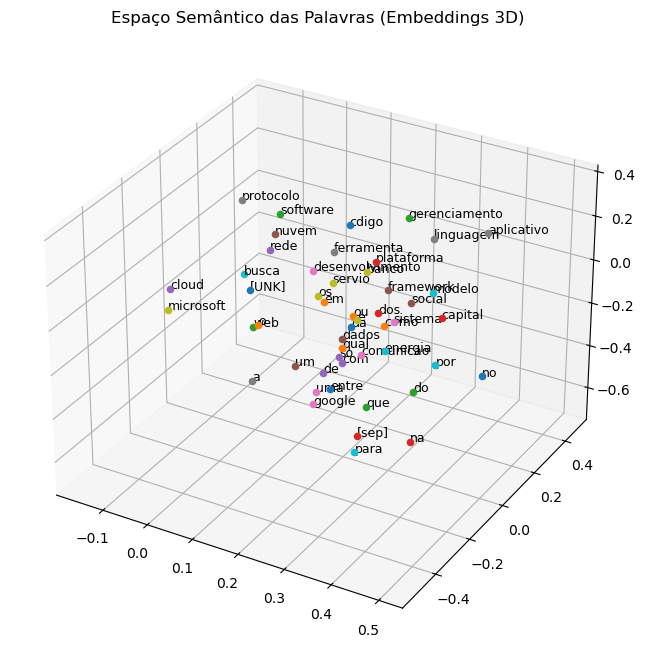

In [32]:
import plotly.graph_objects as go
import numpy as np

# Pegamos os pesos da camada de embedding
weights = emb_layer.get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

# PCA para reduzir de 64D -> 3D
pca = PCA(n_components=3)
weights_3d = pca.fit_transform(weights)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotamos as primeiras 50 palavras para não poluir o gráfico
for i in range(1, 51):
    ax.scatter(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2])
    ax.text(weights_3d[i, 0], weights_3d[i, 1], weights_3d[i, 2], vocab[i], fontsize=9)

ax.set_title("Espaço Semântico das Palavras (Embeddings 3D)")
plt.show()

## 5. Chat Interativo (Inferência Autoregressiva)

O chat agora envia a pergunta + o token `[sep]` e espera o modelo completar a frase palavra por palavra.

In [34]:
def responder(pergunta):
    vocab = vectorize_layer.get_vocabulary()
    # Preparamos o início da sequência
    contexto = pergunta.lower() + " [sep]"
    
    for _ in range(15): # Gera até 15 palavras
        input_tokens = vectorize_layer([contexto])[:, :-1]
        preds = model.predict(input_tokens, verbose=0)
        
        # Pegamos a predição da ÚLTIMA palavra preenchida
        # Encontramos onde termina o texto atual no tensor
        idx_last = np.count_nonzero(input_tokens[0]) - 1
        next_token_idx = np.argmax(preds[0, idx_last, :])
        
        next_word = vocab[next_token_idx]
        if next_word == "" or next_word == "[UNK]": break
        
        contexto += " " + next_word
        if len(contexto.split()) > MAX_SEQUENCE_LEN: break
        
    # Retorna apenas a parte da resposta (após o [sep])
    if "[sep]" in contexto:
        return contexto.split("[sep]")[1].strip()
    return contexto

print("="*30)
while True:
    p = input("VOCÊ: ")
    if p.upper() == "SAIR": break
    print(f"GPT: {responder(p)}")
    print("-" * 20)

VOCÊ:  o que é gpt?


GPT: gpt um modelo de linguagem da openai
--------------------


VOCÊ:  o que é tensorflow?


GPT: tensorflow uma biblioteca de cdigo aberto para machine learning desenvolvida pelo google
--------------------


VOCÊ:  o que aero gerador?


GPT: 
--------------------


VOCÊ:  O que é aerogerador?


GPT: aerogerador um
--------------------


VOCÊ:  O que é GDPR?


GPT: gdpr o regulamento de proteo de dados da europa
--------------------


VOCÊ:  O que são UX e UI?


GPT: ux
--------------------


VOCÊ:  o que é Ux


GPT: ux a experincia do usurio
--------------------


VOCÊ:  Quem criou você?


GPT: 
--------------------


VOCÊ:  Quem criou você


GPT: 
--------------------


VOCÊ:  O que é um modelo Decoder-only


GPT: uma arquitetura de transformer que
--------------------


VOCÊ:  sair


In [36]:
import math

final_loss = history.history['loss'][-1]
perplexity = math.exp(final_loss)

print("Loss final:", final_loss)
print("Perplexity:", perplexity)

Loss final: 0.2848493754863739
Perplexity: 1.3295617484466424
